# **A1 Team2 Project M3**
Topic: European Drug Development

Author: Wen-Hsin Kung

## **1. Data Cleaning**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [116]:
# import data
data = pd.read_csv('drugs.csv')

# Split into human and veterinary data
data_human = data[data['category'] == 'human']
data_vet = data[data['category'] == 'veterinary']

# Drop columns
data_human = data_human.drop(['category', 'species', 'url', 'product_number', 'atc_code'], axis=1)

# Add "admin_time_days" column
data_human['admin_time_days'] = (
    pd.to_datetime(data_human['marketing_authorisation_date'], errors='coerce') -
    pd.to_datetime(data_human['date_of_opinion'], errors='coerce')
).dt.days
data_human = data_human[data_human['admin_time_days'] >= 0]

data_human.head(3)

,medicine_name,therapeutic_area,common_name,active_substance,patient_safety,authorisation_status,additional_monitoring,generic,biosimilar,conditional_approval,...,date_of_refusal_of_marketing_authorisation,marketing_authorisation_holder_company_name,pharmacotherapeutic_group,date_of_opinion,decision_date,revision_number,condition_indication,first_published,revision_date,admin_time_days
0,Adcetris,"Lymphoma, Non-Hodgkin; Hodgkin Disease",brentuximab vedotin,brentuximab vedotin,False,authorised,False,False,False,False,...,NaN,Takeda Pharma A/S,Antineoplastic agents,2012-07-19,2022-11-17,34.0,Hodgkin lymphomaAdcetris is indicated for adul...,2018-07-25T13:58:00Z,2023-03-13T11:52:00Z,98.0
1,Nityr,Tyrosinemias,nitisinone,nitisinone,False,authorised,False,True,False,False,...,NaN,Cycle Pharmaceuticals (Europe) Ltd,"Other alimentary tract and metabolism products,",2018-05-31,2023-03-10,4.0,Treatment of adult and paediatric patients wit...,2018-07-26T14:20:00Z,2023-03-10T17:29:00Z,56.0
2,Ebvallo,Lymphoproliferative Disorders,tabelecleucel,tabelecleucel,False,authorised,True,False,False,False,...,NaN,Pierre Fabre Medicament,NaN,2022-10-13,2023-03-09,2.0,Ebvallo is indicated as monotherapy for treatm...,2022-10-12T16:13:00Z,2023-03-10T13:40:00Z,64.0


In [117]:
data_human.nunique()

medicine_name                                  1008
therapeutic_area                                469
common_name                                     701
active_substance                                743
patient_safety                                    2
authorisation_status                              2
additional_monitoring                             2
generic                                           2
biosimilar                                        2
conditional_approval                              2
exceptional_circumstances                         2
accelerated_assessment                            2
orphan_medicine                                   2
marketing_authorisation_date                    619
date_of_refusal_of_marketing_authorisation        7
marketing_authorisation_holder_company_name     342
pharmacotherapeutic_group                       169
date_of_opinion                                 294
decision_date                                   382
revision_num

## **2. Dimensionality Reduction**

### **2.1 UMAP for binary columns**

In [118]:
# binary columns
binary_flags = [
    'additional_monitoring',
    'orphan_medicine',
    'conditional_approval',
    'exceptional_circumstances',
    'accelerated_assessment',
    'biosimilar',
    'generic'
]

data_human_binary = data_human[['medicine_name'] + binary_flags].copy()
data_human_binary = data_human_binary.replace({True:1, False:0})
data_human_binary.head()

,medicine_name,additional_monitoring,orphan_medicine,conditional_approval,exceptional_circumstances,accelerated_assessment,biosimilar,generic
0,Adcetris,0,1,0,0,0,0,0
1,Nityr,0,0,0,0,0,0,1
2,Ebvallo,1,1,0,1,0,0,0
3,Ronapreve,1,0,0,0,0,0,0
4,Cosentyx,0,0,0,0,0,0,0


In [119]:
import umap
import plotly.express as px
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
df_3d_scaled = scaler.fit_transform(data_human_binary[binary_flags])
df_3d_scaled = pd.DataFrame(df_3d_scaled, columns=data_human_binary[binary_flags].columns)

# Use UMAP to reduce the dimensionality of the data
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.5)
umap_embeddings = reducer.fit_transform(df_3d_scaled)

# Create a DataFrame for the UMAP embeddings
umap_df = pd.DataFrame(umap_embeddings, columns=["UMAP1", "UMAP2", "UMAP3"])

# Create a 3D scatter plot with hover information
fig = px.scatter_3d(
    umap_df,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    opacity=0.3,
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Customize marker size and opacity
fig.update_traces(marker=dict(size=5, opacity=0.7))

# Display the plot
fig.show(renderer="browser")

### **2.2 Text Mining for therapeutic_area and active_substance**

Embedding + averaging is a simple way to represent each record with meaningful semantics. Unlike BoW or N-grams, embeddings capture similarity even when terms are different (common in biomedical names). By averaging token embeddings (or using a sentence embedding), we get one fixed-length vector per drug entry that summarizes its overall meaning. These dense vectors work well with clustering algorithms like KMeans because similar therapeutic areas and substances end up close in vector space. It’s effective, fast, and easy to implement without complex models.

In [120]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

df_tm = data_human.copy()
df_tm = df_tm.fillna("")

df_tm["text"] = df_tm["therapeutic_area"] + " " + df_tm["active_substance"]

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_tm["text"].tolist())

embeddings.shape

(1008, 384)

The embedding results in 384 dimensions, which is a comparative low and proper number. I'll use this outcome to do clustering.

### **2.3 NLP Clustering for condition_indication**

In [122]:
# text preparation
data_human['condition_indication'] = data_human['condition_indication'].fillna('').astype(str)

# Keep rows with valid text and valid time calculation
data_human_clean = data_human[data_human['condition_indication'] != ''].dropna(subset=['admin_time_days']).copy()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# convert the raw text into a numerical matrix
# limit to the top 1000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data_human_clean['condition_indication'])

# k=5
n_topics = 5
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvd')
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# topic id
data_human_clean['topic_id'] = nmf_topics.argmax(axis=1)

# print results
print("====== k=5 topics ======")
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-10:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(f"Topic {topic_idx}: {', '.join(top_features)}")

====== k=5 topics ======
Topic 0: cancer, metastatic, advanced, cell, locally, lung, small, treatment, chemotherapy
Topic 1: adults, years, adolescents, children, treatment, aged, age, older, indicated
Topic 2: diabetes, mellitus, metformin, glycaemic, control, diet, exercise, type, adjunct
Topic 3: patients, adult, treatment, indicated, multiple, disease, chronic, therapy, sclerosis
Topic 4: active, response, methotrexate, inadequate, arthritis, severe, therapy, intolerant, conventional


## **3. Clustering**

### **3.1 Prepare Data**

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# cleaning
df_clustering = data_human.copy()

binary_flags = [
    'additional_monitoring',
    'orphan_medicine',
    'conditional_approval',
    'exceptional_circumstances',
    'accelerated_assessment',
    'biosimilar',
    'generic'
]

# binary -> 0/1
df_clustering[binary_flags] = df_clustering[binary_flags].replace({True: 1, False: 0}).fillna(0)

# numeric
df_clustering["admin_time_days"] = df_clustering["admin_time_days"].fillna(df_clustering["admin_time_days"].median())

# text
X_text = np.array(embeddings)

# condition_indication
df_clustering["condition_indication"] = df_clustering["condition_indication"].fillna("").astype(str)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clustering["condition_indication"])

n_topics = 5
nmf_model = NMF(n_components=n_topics, random_state=42, init="nndsvd")
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# feature blocks
X_binary = df_clustering[binary_flags].to_numpy()
X_num    = df_clustering[["admin_time_days"]].to_numpy()
X_topic  = np.array(nmf_topics)

# merge
w_text = 0.7
w_topic = 1.8
w_other = 1.8

X = np.hstack([
    w_other * np.hstack([X_binary, X_num]),
    w_text  * X_text,
    w_topic * X_topic
])

print("Final feature matrix:", X.shape)

Final feature matrix: (1008, 397)


In [124]:
# scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **3.2 Clustering**

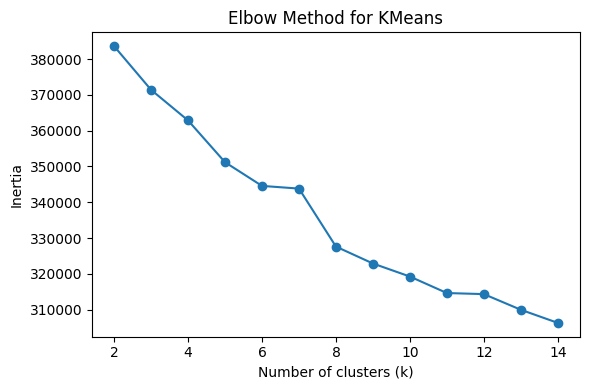

In [125]:
# Elbow
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = X_scaled

inertia = []
K = range(2, 15)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.tight_layout()
plt.show()

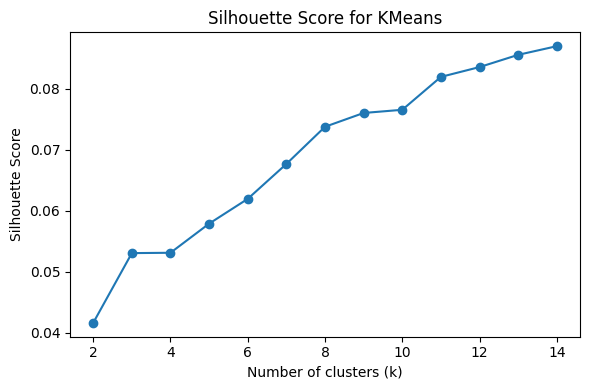

In [126]:
# Silhouette Score
from sklearn.metrics import silhouette_score

sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

plt.figure(figsize=(6,4))
plt.plot(list(K), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for KMeans")
plt.tight_layout()
plt.show()

Combining the Elbow method and Silhouette score, I narrowed the choice to k=8 or k=10. I tried k=10 first, but the binary feature profiles of several clusters looked very similar, so I worried it was over-splitting and switched to k=8 for better interpretability. However, after reviewing the cluster keywords from therapeutic_area and active_substance, k=10 produced clearer, more clinically meaningful separation (e.g., finer distinctions across disease areas and drug types). Therefore, despite the similar binary profiles, I ultimately chose k=10 as the final solution.

In [127]:
# clustering
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
df_clustering["cluster"] = kmeans.fit_predict(X_scaled)

df_clustering.groupby("cluster").size()

cluster
0    131
1    126
2    157
3     76
4     91
5    133
6     69
7     54
8    121
9     50
dtype: int64

There's no tiny cluster.

### **3.3 Clustering results & Assessment**

In [128]:
# binary columns
binary_flags = [
    'additional_monitoring','conditional_approval','exceptional_circumstances','accelerated_assessment','orphan_medicine','biosimilar','generic'
]

# binary + admin_time_days
cols = binary_flags + ["admin_time_days"]

# mean
cluster_profile = df_clustering.groupby("cluster")[cols].mean().round(2)

cluster_profile

,additional_monitoring,conditional_approval,exceptional_circumstances,accelerated_assessment,orphan_medicine,biosimilar,generic,admin_time_days
cluster,,,,,,,,
0,0.35,0.02,0.04,0.05,0.04,0.00,0.18,96.96
1,0.29,0.04,0.01,0.03,0.15,0.00,0.19,71.94
2,0.58,0.06,0.12,0.08,0.38,0.08,0.08,135.50
3,0.20,0.00,0.00,0.00,0.01,0.14,0.16,74.86
4,0.38,0.11,0.02,0.05,0.30,0.13,0.22,70.47
5,0.13,0.01,0.00,0.01,0.06,0.00,0.35,83.45
6,0.39,0.17,0.00,0.07,0.10,0.00,0.20,64.06
7,0.31,0.00,0.00,0.00,0.00,0.44,0.04,95.80
8,0.19,0.02,0.02,0.01,0.02,0.02,0.26,68.26


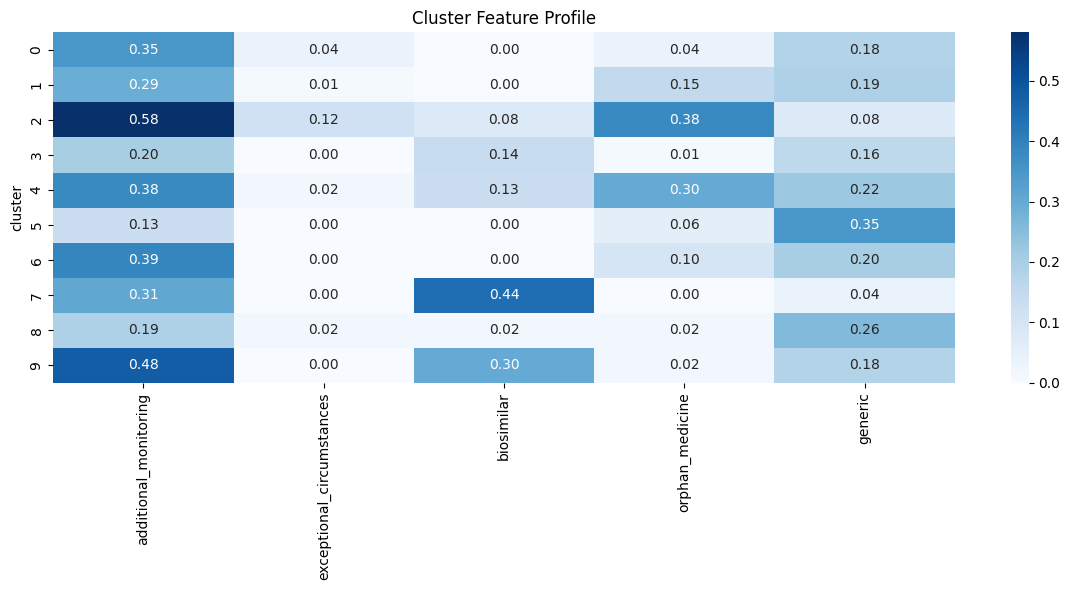

In [132]:
# remove these columns since there is no significant difference:
## 'conditional_approval','accelerated_assessment'
binary_flags_2 = [
    'additional_monitoring','exceptional_circumstances','biosimilar','orphan_medicine','generic'
]

# mean
cluster_profile_2 = df_clustering.groupby("cluster")[binary_flags_2].mean().round(2)

# heatmap
plt.figure(figsize=(12,6))
sns.heatmap(cluster_profile_2,
            annot=True,
            cmap="Blues",
            fmt=".2f")

plt.title("Cluster Feature Profile")
plt.tight_layout()
plt.show()

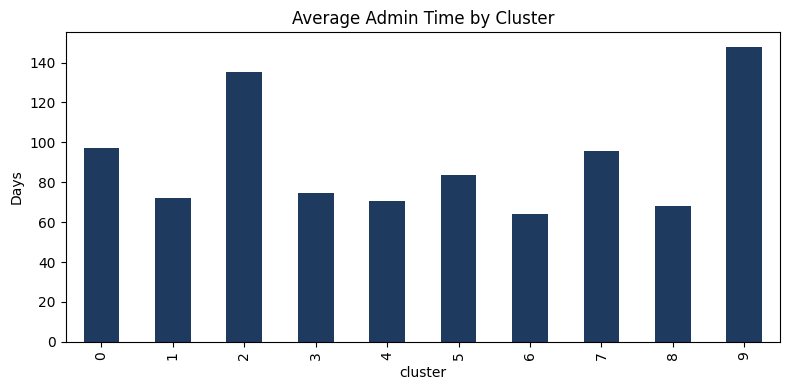

In [130]:
# barplot
cluster_profile["admin_time_days"].plot(
    kind="bar",
    figsize=(8,4),
    title="Average Admin Time by Cluster",
    color="#1f3a5f"
)
plt.ylabel("Days")
plt.tight_layout()
plt.show()

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction import text

# merge text columns
df_clustering["ta"] = df_clustering["therapeutic_area"].fillna("").str.lower().str.replace(";", " ", regex=False)
df_clustering["as"] = df_clustering["active_substance"].fillna("").str.lower().str.replace(";", " ", regex=False)

extra_stopwords = [
    "hydrochloride","monohydrate","dihydrate",
    "acid","chloride","sodium","disodium",
    "human","cells","type","beta",
    "acetate","fumarate","mesilate",
    "rdna","autologous","containing","conjugated","interferon",
    "ex","nerve"
]

all_stopwords = list(text.ENGLISH_STOP_WORDS.union(extra_stopwords))

def show_top_words(text_col, topn=5):
    docs = df_clustering.groupby("cluster")[text_col].apply(lambda x: " ".join(x)).sort_index()
    vec = TfidfVectorizer(stop_words=all_stopwords, min_df=2)
    X = vec.fit_transform(docs)
    words = np.array(vec.get_feature_names_out())

    for i, c in enumerate(docs.index):
        top_idx = X[i].toarray().ravel().argsort()[::-1][:topn]
        print(f"Cluster {c} top {text_col} words:", words[top_idx])

print("=== therapeutic_area keywords ===")
show_top_words("ta", topn=5)

print("\n=== active_substance keywords ===")
show_top_words("as", topn=5)

=== therapeutic_area keywords ===
Cluster 0 top ta words: ['infections' 'hepatitis' 'bacterial' 'chronic' 'tract']
Cluster 1 top ta words: ['prostatic' 'neoplasms' 'pain' 'rejection' 'psoriasis']
Cluster 2 top ta words: ['neutropenia' 'diseases' 'anemia' 'inborn' 'disease']
Cluster 3 top ta words: ['diabetes' 'mellitus' 'macular' 'wet' 'edema']
Cluster 4 top ta words: ['leukemia' 'lymphoma' 'myeloma' 'multiple' 'cell']
Cluster 5 top ta words: ['disorders' 'sclerosis' 'multiple' 'disease' 'dysfunction']
Cluster 6 top ta words: ['carcinoma' 'small' 'cell' 'non' 'lung']
Cluster 7 top ta words: ['arthritis' 'rheumatoid' 'psoriasis' 'colitis' 'ulcerative']
Cluster 8 top ta words: ['hypertension' 'obstructive' 'chronic' 'disease' 'asthma']
Cluster 9 top ta words: ['neoplasms' 'carcinoma' 'cell' 'small' 'non']

=== active_substance keywords ===
Cluster 0 top as words: ['recombinant' 'antigen' 'encoding' 'phosphate' 'sulfate']
Cluster 1 top as words: ['posaconazole' 'citrate' 'phosphate' 'dihy

**Overall clustering rationale**

The final clustering structure is primarily driven by therapeutic_area semantics (via embeddings and topic modeling), while regulatory-related binary features (e.g., additional monitoring, orphan status, biosimilar, generic) and administrative time further differentiate subgroups. The heatmap shows that clusters are not randomly separated; instead, certain groups display distinct regulatory profiles (e.g., high orphan or biosimilar proportions), while others are characterized by longer administrative timelines. This indicates that the segmentation reflects both clinical domains and regulatory patterns.

**Weight adjustment and final selection**

During model tuning, I experimented with different weight combinations for text embeddings, topic features, and other regulatory variables. Increasing the weights of binary and topic features strengthened regulatory differentiation but sometimes reduced clinical interpretability. Conversely, overly emphasizing text features led to semantically coherent clusters but weaker regulatory distinction. After testing multiple configurations and comparing k=8 and k=10, I initially preferred k=8 because some clusters in k=10 showed similar binary profiles. However, further inspection of therapeutic_area and active_substance keywords revealed that k=10 provided clearer clinical separation (e.g., splitting oncology into distinct subgroups and isolating rare hematologic conditions). Therefore, I selected k=10 as it achieved better balance between interpretability and structural richness.

**Cluster characteristics summary (k = 10)**

Cluster 0 – Infectious diseases / hepatitis: Infection-focused drugs, including recombinant or antigen-related products, with moderately high additional monitoring.

Cluster 1 – Mixed inflammatory/oncology-related indications: Includes prostatic neoplasms and immune-related conditions; moderate regulatory activity.

Cluster 2 – Hematologic supportive care / rare diseases: High orphan proportion and highest additional monitoring; longest administrative timelines; includes filgrastim-type agents.

Cluster 3 – Metabolic & ophthalmic: Diabetes and macular edema; GLP-1 analogues (liraglutide, semaglutide) present.

Cluster 4 – Hematologic malignancies: Leukemia, lymphoma, myeloma; targeted or biologic oncology agents.

Cluster 5 – Neurological disorders: Multiple sclerosis and dysfunction-related indications; moderate timelines.

Cluster 6 – Solid tumor oncology: Lung and small-cell carcinoma; immune-oncology drugs (e.g., nivolumab).

Cluster 7 – Autoimmune / inflammatory diseases: Rheumatoid arthritis, psoriasis, colitis; high biosimilar proportion.

Cluster 8 – Cardiovascular / respiratory: Hypertension, asthma, obstructive diseases; higher generic ratio.

Cluster 9 – Advanced oncology subgroup: Neoplasm-focused cluster with longest administrative time, likely representing complex or high-risk cancer therapies.